## 准备数据

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 下载数据集到本地
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
dataset_path = keras.utils.get_file("auto-mpg.data", url)

# 使用Pandas读取数据
column_names = ['MPG','气缸','排量','马力','重量','加速度', '年份', '产地']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
# 查看前3条数据
dataset.head(3)

,MPG,气缸,排量,马力,重量,加速度,年份,产地
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1


In [2]:
dataset.isna().sum()

MPG    0
气缸     0
排量     0
马力     6
重量     0
加速度    0
年份     0
产地     0
dtype: int64

In [3]:
dataset = dataset.dropna()

In [4]:
origin = dataset.pop('产地')
dataset['美国'] = (origin == 1)*1.0
dataset['欧洲'] = (origin == 2)*1.0
dataset['日本'] = (origin == 3)*1.0
# 看一看转换后的结果
dataset.head(3)

,MPG,气缸,排量,马力,重量,加速度,年份,美国,欧洲,日本
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0


In [5]:
# 训练集 80%， 测试集 20%
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

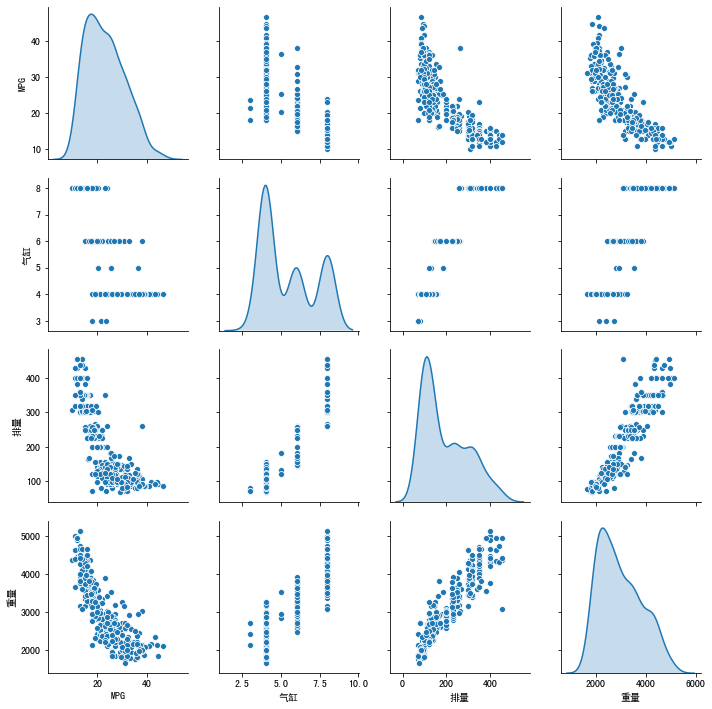

In [6]:
# 解决中文乱码问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

sns.pairplot(train_dataset[["MPG", "气缸", "排量", "重量"]], diag_kind="kde")

In [7]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
气缸,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
排量,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
马力,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
重量,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
加速度,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
年份,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
美国,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
欧洲,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
日本,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [8]:
# 分离 label
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [9]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [10]:
def build_model():
  input_dim = len(train_dataset.keys())
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[input_dim,]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  model.compile(loss='mse', metrics=['mae', 'mse'],
                optimizer=tf.keras.optimizers.RMSprop(0.001))
  return model

model = build_model()
# 打印模型的描述信息，每一层的大小、参数个数等
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


In [11]:
import sys

    
EPOCHS = 1000

class ProgressBar(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    # 显示进度条
    self.draw_progress_bar(epoch + 1, EPOCHS)

  def draw_progress_bar(self, cur, total, bar_len=50):
    cur_len = int(cur / total * bar_len)
    sys.stdout.write("\r")
    sys.stdout.write("[{:<{}}] {}/{}".format("=" * cur_len, bar_len, cur, total))
    sys.stdout.flush()

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split=0.2, verbose=0,
  callbacks=[ProgressBar()])

[==================================================] 1000/1000

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(3)

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
997,3.409430,1.230940,3.409431,8.946074,2.340401,8.946074,997
998,3.577053,1.250938,3.577053,9.061930,2.383534,9.061931,998
999,3.459321,1.242559,3.459321,9.225462,2.375621,9.225462,999


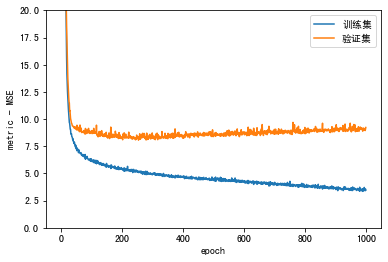

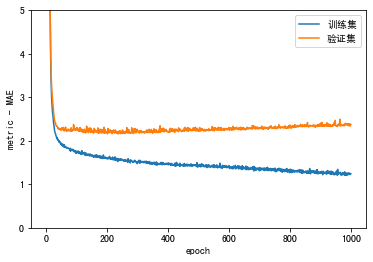

In [13]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.xlabel('epoch')
  plt.ylabel('metric - MSE')
  plt.plot(hist['epoch'], hist['mse'], label='训练集')
  plt.plot(hist['epoch'], hist['val_mse'], label = '验证集')
  plt.ylim([0, 20])
  plt.legend()
  
  plt.figure()
  plt.xlabel('epoch')
  plt.ylabel('metric - MAE')
  plt.plot(hist['epoch'], hist['mae'], label='训练集')
  plt.plot(hist['epoch'], hist['val_mae'], label = '验证集')
  plt.ylim([0, 5])
  plt.legend()
  
plot_history(history)

[===                                               ] 73/1000

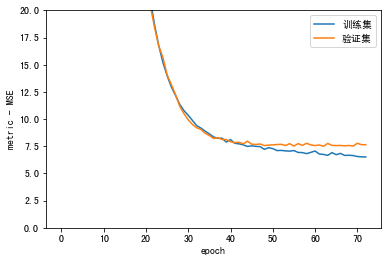

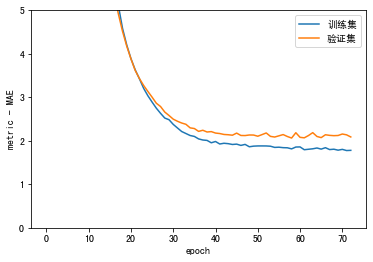

In [14]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, ProgressBar()])
plot_history(history)

In [15]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("测试集平均绝对误差(MAE): {:5.2f} MPG".format(mae))

测试集平均绝对误差(MAE):  1.82 MPG


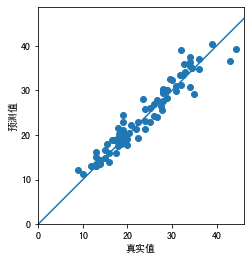

In [16]:
test_pred = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_pred)
plt.xlabel('真实值')
plt.ylabel('预测值')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])